<a href="https://colab.research.google.com/github/rahiakela/computer-vision-case-studies/blob/master/image-segmentation/semantic_segmentation_using_tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Semantic Segmentation Using TensorFlow Keras

In this notebook, we discuss semantic segmentation using TensorFlow Keras. Readers are expected to have a fundamental knowledge of deep learning, image classification and transfer learning.

Reference:

https://analyticsindiamag.com/semantic-segmentation-using-tensorflow-keras/

## Setup

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
from scipy import io
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt

## Prepare Segmentation Dataset

We use [Clothing Co-Parsing public dataset](http://www.sysu-hcp.net/clothing-co-parsing-by-joint-image-segmentation-and-labeling/) as our supervised dataset. This dataset has 1000 images of people (one person per image). There are 1000 label images corresponding to those original images. Label images have 59 segmented classes corresponding to classes such as hair, shirt, shoes, skin, sunglasses and cap. 

Download the images from the source.

In [3]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

Cloning into 'clothing-co-parsing'...
remote: Enumerating objects: 4234, done.
remote: Total 4234 (delta 0), reused 0 (delta 0), pack-reused 4234
Receiving objects: 100% (4234/4234), 124.59 MiB | 46.42 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.


In [4]:
!echo $PWD

/content


Have a look at the dataset source files.

In [5]:
!ls clothing-co-parsing/

annotations  label_list.mat  photos	show_image_anno.m
example.jpg  LICENSE	     README.md	show_pixel_anno.m


Input images are in the photos directory, and labelled images are in the annotations directory. Let’s extract the input images from the respective source directory.

In [6]:
images = []
for i in range(1, 1001):
  url = "./clothing-co-parsing/photos/%04d.jpg" % (i)
  img = cv2.imread(url)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images.append(tf.convert_to_tensor(img))

Let’s extract the labelled images (segmented images) from the respective source directory.

In [7]:
masks = []
for i in range(1, 1001):
  url = "./clothing-co-parsing/annotations/pixel-level/%04d.mat" % (i)
  file = io.loadmat(url)
  mask = tf.convert_to_tensor(file["groundtruth"])
  masks.append(mask)

How many examples do we have now?

In [8]:
len(images), len(masks)

(1000, 1000)

As mentioned in the source files, there are 1000 images and 1000 labels. Visualize some images to get better insights.

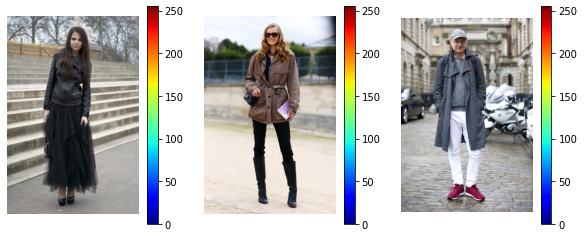

In [9]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

The images are 3-channel colour images with values ranging from 0 to 255. Images seem to have different sizes. We need to scale images and resize them to some common shape. Let’s visualize label images corresponding to the above input images.

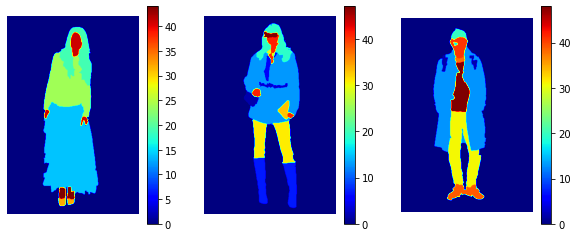

In [11]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show() 

Each colour in the above images refer to a specific class. We observe that the person and her/his wearings are segmented, leaving the surrounding unsegmented.

In [12]:
masks[0].numpy().min(), masks[0].numpy().max()

(0, 55)

The label values start at 0 and go all the way through 59.

## Model Selection